<a href="https://colab.research.google.com/github/mohammad2682/FVS-SVM-RKHS/blob/main/SVM_RKHS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
!git clone https://github.com/mohammad2682/FVS-SVM-RKHS

Cloning into 'FVS-SVM-RKHS'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 107 (delta 38), reused 41 (delta 17), pack-reused 0
Receiving objects: 100% (107/107), 875.57 KiB | 4.68 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [3]:
def sigma(df):
  N = df.shape[0]
  sigma = []
  for i in range(N):
    for j in range(i+1, N):
      x_i = df.iloc[[i], :-1]
      x_j = df.iloc[[j], :-1]
      sigma.append(np.linalg.norm(x_i.values - x_j.values))
  return 0.1 * np.max(sigma)

In [4]:
def K(FV1, FV2, sigma):
  dist = np.linalg.norm(FV1-FV2)
  return np.exp(-1*np.square(dist)/(2*sigma))

In [5]:
def give_KSS(S, sigma):
  KSS = []
  for vec1 in S:
    for vec2 in S:
      k = K(np.array(vec1), np.array(vec2), sigma = sigma)
      KSS.append(k)

  return np.array(KSS).reshape((len(S), len(S)))

In [6]:
def give_KSx(S, x, sigma):
  KSx = []
  for s in S:
    kx = K(np.array(s), x, sigma = sigma)
    KSx.append(kx)
  return np.array(KSx).reshape((len(S), 1))

In [7]:
def minor_major(df):
  cls = df.iloc[:,-1].unique()
  cls0 = df[df.iloc[:,-1]==cls[0]].shape[0]
  cls1 = df[df.iloc[:,-1]==cls[1]].shape[0]
  minor = cls[0]
  major = cls[1]
  if cls0>cls1:
    minor = cls[1]
    major = cls[0]
  return minor, major

In [8]:
def S_creator(df, FV1):
  df_new = df.drop(index = FV1.index)
  FV1 = FV1.iloc[0].values
  tau = min(0.001, 1/df.shape[0]) #minimum of 0.001, 1/N
  S = [list(FV1)]
  cnt = 1
  for vec in df_new.iloc[:, :-1].values:
    KSx = give_KSx(S, vec, sigma = sig)
    KSS = give_KSS(S, sigma = sig)
    LF = abs(1-(np.dot(np.dot(np.transpose(KSx), np.linalg.inv(KSS)), KSx)))
    #print(LF)
    if LF > tau:
      S.append(list(vec))
      cnt += 1
      if cnt == 5:
        break
  return S

In [9]:
def give_landa(df, minor_cls, major_cls):
  minor = df[df["Class"] == minor_cls]
  major = df[df["Class"] == major_cls]
  landa = []
  for col in df.columns[:-1]:
    mean_minor = minor[col].mean()
    mean_major = major[col].mean()
    var_minor = minor[col].var()
    var_major = major[col].var()
    landa_i = np.square(mean_minor - mean_major)/(var_minor - var_major)
    landa.append(landa_i)
  return landa

In [10]:
df = pd.read_csv("FVS-SVM-RKHS/datasets/pima.csv")
df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,14,175,62,30,0,33.6,0.212,38,tested_positive
1,4,146,78,0,0,38.5,0.520,67,tested_positive
2,15,136,70,32,110,37.1,0.153,43,tested_positive
3,3,107,62,13,48,22.9,0.678,23,tested_positive
4,3,169,74,19,125,29.9,0.268,31,tested_positive


In [64]:
df_test1 = df.iloc[:13, :]
df_test2 = df.iloc[-25:, :]
df_test = pd.concat([df_test1, df_test2]).reset_index(drop=True)
df_test = df_test[["preg", "plas", "skin", "class"]]

# if you want to train with whole data, uncomment below line
#df_test = df.copy()

In [65]:
sig = sigma(df = df_test)
minor_cls, major_cls = minor_major(df_test)

In [66]:
print(sig)
print(minor_cls, major_cls)

19.467665499489147
tested_positive tested_negative


In [67]:
df_test["class"].value_counts()

tested_negative    24
tested_positive    14
Name: class, dtype: int64

In [68]:
minor_df = df_test[df_test["class"]==minor_cls]
S_T = []
FV_T = pd.DataFrame()
for i in range(minor_df.shape[0]):
  FV1 = minor_df.iloc[[i], :-1]
  S_T.append(S_creator(df_test, FV1))
  FV_T = pd.concat([FV_T, FV1])

In [69]:
landa_max = -1000
for i, S in enumerate(S_T):

  FV1 = FV_T.iloc[[i]]
  df_new = df_test.drop(index = FV1.index, axis = 0 )
  cls = []
  flag = 0
  #sort Data
  for vector in df_new.values:
    vec = np.array(list(vector[:-1]))
    cls.append(vector[-1])
    KSx = give_KSx(S, vec, sigma = sig)
    KSS = give_KSS(S, sigma = sig)
    DSS = np.sqrt(KSS)
    beta = np.dot(np.dot(np.transpose(KSx), np.linalg.inv(KSS)), DSS)
    if flag == 0:
      B = beta
      flag = -1
      continue
    B = np.concatenate((B, beta))

  B_df = pd.DataFrame(B)
  B_df["Class"] = cls

  landa = give_landa(B_df, minor_cls, major_cls)

  landa_t = np.sum(landa)/len(S)
  if landa_t > landa_max:
    print(landa_t)
    landa_max = landa_t
    best_S = S

0.08726243728375886
0.10301348474186764


## Second Section

In [70]:
for m in range(np.shape(best_S)[0]):
  omeg_m = []
  for n in range(np.shape(best_S)[0]):
    omeg_mn = np.sum(np.dot(B_df.iloc[:, m], B_df.iloc[:, n]))
    omeg_m.insert(n, omeg_mn)
  if m == 0:
    omeg = omeg_m
    continue
  omeg = list(np.concatenate((omeg, omeg_m)))
omeg = np.array(omeg).reshape((np.shape(best_S)[0], np.shape(best_S)[0]))

In [71]:
H = []
for m in range(np.shape(best_S)[0]):
  H_j = np.sum(B_df.iloc[m, :-1])
  H_m = np.sum(np.dot(B_df.iloc[:,m], (1-H_j)))
  H.insert(m, H_m)

In [72]:
tau = H.copy()

In [73]:
C = []
for m in range(np.shape(best_S)[0]):
  c_val = 1 - np.sum(B_df.iloc[m, :-1])
  C.insert(m, c_val)
C = np.sum(np.square(C))

In [74]:
B_df["y_i"] = B_df['Class']
B_df["y_i"].replace({minor_cls: -1, major_cls: 1}, inplace=True)

In [75]:
P = []
for m in range(np.shape(best_S)[0]):
  P_m = np.sum(np.dot(B_df.iloc[:, m], B_df["y_i"]))
  P.insert(m, P_m)

In [76]:
L = np.sum(np.dot((1 - B_df.iloc[:, :-2].sum(axis=1)), B_df.iloc[:, -1]))

In [77]:
H = np.array(H).reshape((-1, 1))
tau = np.array(tau).reshape((-1, 1))
P = np.array(P).reshape((-1, 1))

In [78]:
row_a = np.concatenate((omeg, H), axis = 1)
row_b = np.append(tau.transpose(), C)
row_b = row_b.reshape((1,row_b.shape[0]))
A = np.concatenate((row_a, row_b), axis = 0)

In [79]:
Z = np.append(P, L).reshape((-1, 1))

In [80]:
output = np.linalg.solve(A, Z)
y_hat = output[:5]
b = output[-1]

In [81]:
print("y_hat: ", y_hat)
print("b: ", b)

y_hat:  [[-145.15468493]
 [   9.44876496]
 [  -0.34252217]
 [  -0.99157199]
 [   9.45855301]]
b:  [-6.68553345]


## g(xi)

In [82]:
B_df["g(xi)"] = np.nan
for i in range(B_df.shape[0]):
  B_df.loc[i, "g(xi)"] = np.dot(B_df.iloc[i, 0:-3], (y_hat-b)) + b

tested_negative  g(xi) mean value:  -5.687673399953385
tested_positive  g(xi) mean value:  -3.791829024731124


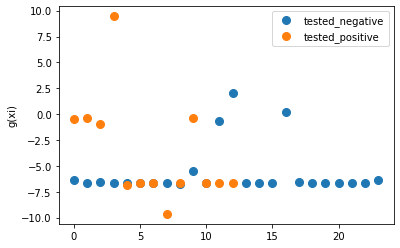

In [83]:
groups = B_df.groupby('Class')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(np.arange(0, group.shape[0]), group["g(xi)"], marker='o', linestyle='', ms=8, label=name)
    print(name, " g(xi) mean value: ", np.mean(group["g(xi)"]))
ax.legend()
plt.ylabel("g(xi)")

plt.show()

In [102]:
# change threshold to change the model's performance:
classifier_thresh = -3

B_df["y_pred"] = major_cls
for i, g_xi in enumerate(B_df["g(xi)"]):
  if g_xi > classifier_thresh:
    B_df.loc[i, "y_pred"] = minor_cls

## Model Evaluation

* Confusion Matrix

In [103]:
cls_types= np.array([major_cls, minor_cls])

In [104]:
Y_pred = B_df["y_pred"].values
Y_true = B_df["Class"].values

Text(0.5, 88.97374999999997, 'Predicted')

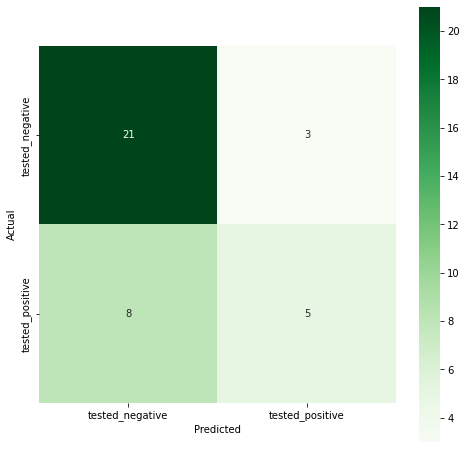

In [105]:
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=cls_types, yticklabels=cls_types)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

In [106]:
TN = cm[0][0]
TP = cm[1][1]
FN = cm[0][1]
FP = cm[1][0]

TPR = TP / (TP+FN)
TNR = TN / (TN+FP)
precision = TP / (TP+FP)

In [107]:
G_mean = np.sqrt(TPR*TNR)
F_measure = (2*precision*TPR)/(precision+TPR)

In [108]:
print("G-mean for threshold of ", classifier_thresh, " is: ", G_mean)
print("F-measure for threshold of ", classifier_thresh, " is: ", F_measure)

G-mean for threshold of  -3  is:  0.6727452763836783
F-measure for threshold of  -3  is:  0.4761904761904762


In [109]:
acc = (TP+TN) / (TP+TN+FN+FP)
print(acc)

0.7027027027027027


In [110]:
print(precision)

0.38461538461538464
